
Given the notebook, https://github.com/jpata/particleflow/blob/nb_clic_evaluate/notebooks/mlpf-clic-evaluate.ipynb as it loads the model, sets the weights, run the inference on a  set of events and compare the true vs. Predicted value for pT on a smaller subset.

**Task(11/27/2023):**

Do the quantization of the model, and the conversion of the data, all in one notebook along with the model inference.

<span style="color:red;">
  
1. Standardize the P_T value before quantizing.
2. Three P_T plots:
    1. Raw P_T (Number of particles vs P_T (GeV))
    2. P_T after standardization (X-axis should be arbitrary units)
    3. After int8 quantization. Centers at 0 and range should be between -127, 127)
      
3. Upon standardization, there could be a few values which could be out of the range of (-127, 127). How to deal with the outliers? One of the methods is to put all of them in the last bin. Are there any other methods available?
  
4. Fix bin size does not give resolution. We can lose information if we discard those outliers.
  
5. Print the true and predicted P_T values. Should be in the INT8 range.
  
6. Put on the distribution if it makes sense.
</span>

<span style="color:green;">
    
1. Read about the dataset
    
2. Understand the outputs what you are plotting
</span>

**Date(11/28/2023)**
1. We need to standradization to whole datasample which is 100 in our case. 
2. Plot the datasample before and after standradization ??
3. Or do we only need to standradize the True P_T?
4. What type of output you have right now?

Load the quantized model, load the quantized weights, and convert all of the data using quantization and then mesaure the inference

some point you need to use something like tf.lite.TFLiteConverter?
https://www.tensorflow.org/lite/performance/post_training_integer_quant
or is there another way?

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

2023-11-29 00:40:11.802364: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 00:40:12.262113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import ROOT

Welcome to JupyROOT 6.28/11


In [3]:
import sys
sys.path += ["../../../mlpf/particleflow/mlpf/"] # positions on the lxplus
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [4]:
config, _ = parse_config("../../../mlpf/particleflow/parameters/clic.yaml") #positions on the lxplus

In [5]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))


2023-11-29 00:41:01.494892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 00:41:01.531842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 00:41:01.533843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_2 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [7]:
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)
## These files hosted at https://huggingface.co/jpata/particleflow/tree/clic_clusters_v1.6

In [8]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../mlpf/tensorflow_datasets/') # Tensorflow datsets positions in the lxplus
dss = ds_builder.as_data_source("test")



In [9]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [10]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)


In [11]:
data = list(tfds.as_numpy(tf_dataset))


In [12]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [20]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [21]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

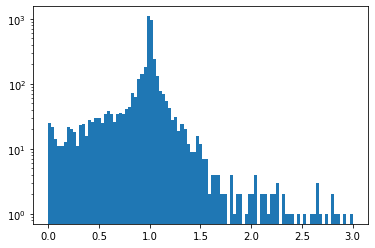

In [22]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

Plotting the P_T in the ROOT before quantizing(does it make sense??)

In [27]:
print(true_pt.shape)
print(pred_pt.shape)

(4250,)
(4250,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: true_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: pred_hist (Potential memory leak).


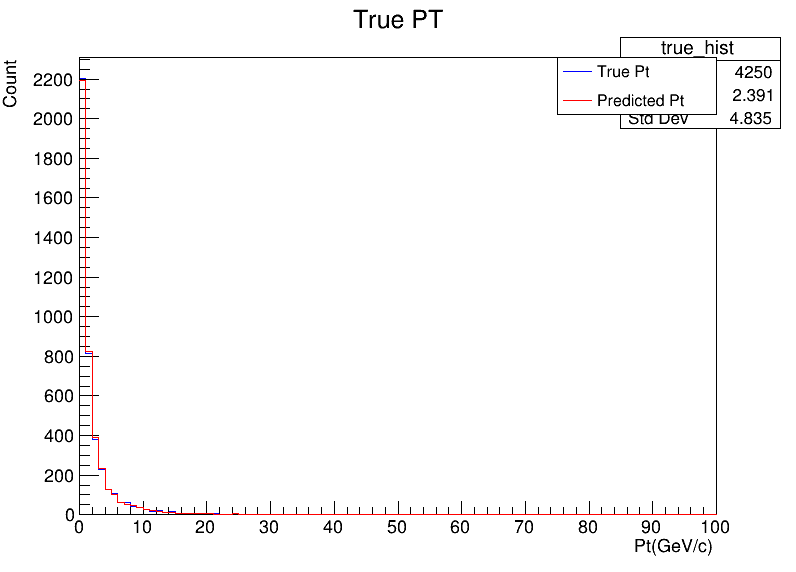

In [23]:
import ROOT
canvas = ROOT.TCanvas("canvas", "True and Predicted PT", 800, 600)

true_pt_array = np.array(true_pt)
pred_pt_array = np.array(pred_pt)

true_hist = ROOT.TH1F("true_hist", "True PT", 100, 0, 100)  # Adjust the binning as needed
pred_hist = ROOT.TH1F("pred_hist", "Predicted PT", 100, 0, 100)

# Filling histograms
for value in true_pt_array:
    true_hist.Fill(value)

for value in pred_pt_array:
    pred_hist.Fill(value)

# Set histogram properties
true_hist.SetLineColor(ROOT.kBlue)
pred_hist.SetLineColor(ROOT.kRed)

# Draw histograms
true_hist.Draw()
pred_hist.Draw("SAME")  # Draw on the same canvas

# Add legend
legend = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
legend.AddEntry(true_hist, "True Pt", "l")
legend.AddEntry(pred_hist, "Predicted Pt", "l")
legend.Draw()

# Set axis titles
true_hist.GetXaxis().SetTitle("Pt(GeV/c)")
true_hist.GetYaxis().SetTitle("Count")

# Show the canvas
canvas.Draw()


In [28]:
print("Maximum True PT:", np.max(true_pt_array))
print("Maximum Predicted PT:", np.max(pred_pt_array))


Maximum True PT: 172.95319
Maximum Predicted PT: 173.13539


### standardize the true P_t value
To standardize the true  $P_t$  values (transverse momentum) around 0 with a variance of 1,

 z = $\frac{{x - \mu}}{{\sigma}}$

where:

 z  is the standardized value,\
 x  is the original value,\
 $\mu$  is the mean of the original values, and\
 $\sigma$  is the standard deviation of the original values.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: true_hist (Potential memory leak).


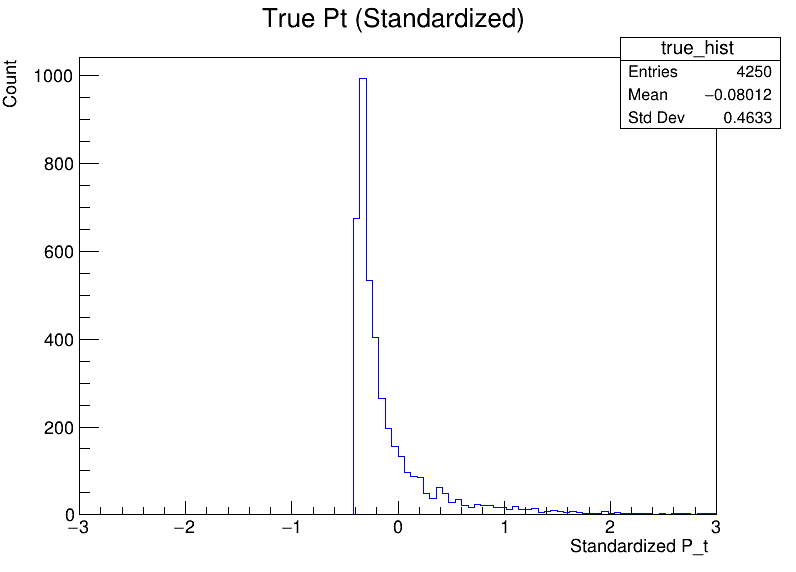

In [29]:
import ROOT

# Create a ROOT canvas
canvas = ROOT.TCanvas("canvas", "True Pt", 800, 600)

# Convert true_pt_array to an array
true_pt_array = np.array(true_pt)

# Standardize true_pt_array
mean_true_pt = np.mean(true_pt_array)
std_true_pt = np.std(true_pt_array)
standardized_true_pt_array = (true_pt_array - mean_true_pt) / std_true_pt

# Create histogram for true values
true_hist = ROOT.TH1F("true_hist", "True Pt (Standardized)", 100, -3, 3)  # Adjust the binning as needed

# Fill histogram
for value in standardized_true_pt_array:
    true_hist.Fill(value)

# Set histogram properties
true_hist.SetLineColor(ROOT.kBlue)

# Add legend
legend = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
legend.AddEntry(true_hist, "True Pt (Standardized)", "l")
legend.Draw()

# Draw histogram
true_hist.Draw()

# Set axis titles
true_hist.GetXaxis().SetTitle("Standardized P_t")
true_hist.GetYaxis().SetTitle("Count")

# Show the canvas
canvas.Draw()


In [88]:
# Printing he Standaradize value
print(standardized_true_pt_array)

[0.6875294  0.1931029  0.22693802 ... 0.19341516 0.15034209 0.70134234]


## Quantized data into the unquantized model

Quantizing the data into INT8 before feeding it into the model

In [30]:
# Quantize input data
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]


In [31]:
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]


In [32]:
ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


In [33]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs_tf)):
    ret = model(Xs_tf[ibatch])

    mask_true_particles = ys_quantized[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [29]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

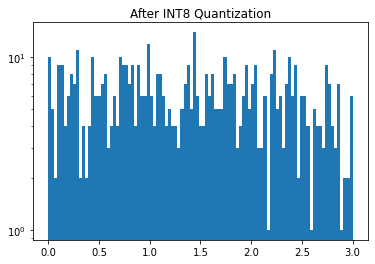

In [30]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.savefig('Output_after_INT8_quantization.png')

Above one is the output with the quantized dataset but not quantized model. We were wokring with the Dynamic Range Quantization. 
Dynamic range quantization is a recommended starting point because it provides reduced memory usage and faster computation without you having to provide a representative dataset for calibration. This type of quantization, statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision.


## Quantized Model with the Quantized Dataset

Let's try with **[quantized model](https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization_of_weights_and_activations)**, Post-training qunatization method, Dynamic range quantization. 

## Dynamic Range Quantization

Converting the model using dynamic range quantization(https://www.tensorflow.org/lite/performance/post_training_integer_quant):
Let's enable the default optimizations flag to quantize all fixed parameters (such as weights):
The model is now a bit smaller with quantized weights, but other variable data is still in float format.


In [47]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()


2023-11-28 13:25:24.414998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-28 13:25:24.415167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-28 13:25:24.417567: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmptgdyirrc
2023-11-28 13:25:24.485779: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-28 13:25:24.485821: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmptgdyirrc
2023-11-28 13:25:24.764613: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-28 13:25:25.715335: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmptgdyirrc
2023-11-28 13:25:26.253185: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: O

In [48]:
# Measuring the size of the quantized tflite model
# Saving the model
import os

with open('quantized_tflite_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
    
model_size = os.path.getsize('quantized_tflite_model.tflite')

print(f"Size of the quantized model: {model_size} bytes")

Size of the quantized model: 5963072 bytes


In [49]:
# Load the quantized TFlite model
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [50]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [51]:
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 111,  17], dtype=int32),
  'shape_signature': array([ -1, 111,  17], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [52]:
#  Xs_quantized is a list of quantized input data
input_data = Xs_quantized[ibatch]

# Print shapes for debugging
print("Input Data Shape:", input_data.shape)
print("Expected Input Shape:", input_details[0]['shape'][1:])


Input Data Shape: (10, 147, 17)
Expected Input Shape: [111  17]


In [53]:
# Assuming you want to use the first 111 samples as a single batch
input_data_reshaped = input_data[:111, :, :]

# Remove the singleton batch dimension
input_data_reshaped = np.squeeze(input_data_reshaped)


# Check the shape after reshaping
print("Reshaped Input Data Shape:", input_data_reshaped.shape)



Reshaped Input Data Shape: (10, 147, 17)


Run the inference on the quantized TFLite model: \
**Something is not right here**
Check this one https://www.tensorflow.org/lite/performance/post_training_integer_quant


## 11/22/23
## Quantization for the model

Trying with dynamic range quantization for both the model and the dataset.the model is not constructed using standard Keras layers, leading to difficulties with quantization.

If the model contains custom layers or non-Keras components, it might not be straightforward to apply dynamic range quantization directly. In such cases, you may consider using a different quantization approach like post-training quantization.

We will go with Post-Training Quantization

In [54]:
import tensorflow_model_optimization as tfmot

In [55]:
# Convert the new model to a TensorFlow Lite model

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()



2023-11-28 13:27:23.319131: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-28 13:27:23.319267: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-28 13:27:23.319654: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/sraj/tmpiyllq1yj
2023-11-28 13:27:23.380430: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-11-28 13:27:23.380499: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/sraj/tmpiyllq1yj
2023-11-28 13:27:23.662809: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-28 13:27:24.601453: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/sraj/tmpiyllq1yj
2023-11-28 13:27:25.200741: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: O

In [56]:
# Save the TensorFlow Lite model to a file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)

### Quantize the dataset
To quantize the dataset, you can apply quantization to the features and labels before feeding them to the model. You can achieve this by normalizing the values to a quantized range.

In [57]:
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]

ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


convert the quantized data to TensorFlow tensors and proceed with inference on the quantized model:

In [58]:
# Convert quantized features to TensorFlow tensors
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]

# Convert quantized labels to TensorFlow tensors
ys_tf = [tf.convert_to_tensor(y_q, dtype=tf.float32) for y_q in ys_quantized]


After converting the data to TensorFlow tensors, you can perform inference using your quantized model:



In [59]:
# Assuming you have a TensorFlow Lite quantized model (quantized_tflite_model)
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()


In [60]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [61]:
# Checking the expected shape of the input tensor
expected_input_shape = input_details[0]['shape']
print("Expected input shape:", expected_input_shape)

Expected input shape: [  1 111  17]


In [62]:
# Verify the shape of your input tensor (X_q)
print("Shape of X_q:", X_q.shape)

NameError: name 'X_q' is not defined

In [63]:
# Reshape X_q to match the expected input shape
X_q_reshaped = np.reshape(X_q, (1, 111, 17))

NameError: name 'X_q' is not defined

In [64]:
X_q_reshaped.shape
print("Shape of X_q_reshaped:", X_q_reshaped.shape)

NameError: name 'X_q_reshaped' is not defined

In [65]:
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], X_q_reshaped)

NameError: name 'X_q_reshaped' is not defined

In [66]:
# Run inference
interpreter.invoke()

In [67]:
# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])


In [68]:
import time

start_time = time.time()

# Create an interpreter for the quantized model
interpreter_quantized = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter_quantized.allocate_tensors()


In [69]:
# Lists to store true and predicted pt values
true_pts_quantized = []
pred_pts_quantized = []


In [70]:
# Measure inference time and process output for the quantized dataset
inference_times_quantized = []


In [71]:
print("Shape of X_q before reshaping:", X_q.shape)


NameError: name 'X_q' is not defined

In [72]:
for X_q in Xs_tf:
    # Print the shape of X_q before reshaping
    print("Shape of X_q before reshaping:", X_q.shape)
    
    
    

Shape of X_q before reshaping: (10, 111, 17)
Shape of X_q before reshaping: (10, 186, 17)
Shape of X_q before reshaping: (10, 142, 17)
Shape of X_q before reshaping: (10, 90, 17)
Shape of X_q before reshaping: (10, 111, 17)
Shape of X_q before reshaping: (10, 195, 17)
Shape of X_q before reshaping: (10, 100, 17)
Shape of X_q before reshaping: (10, 81, 17)
Shape of X_q before reshaping: (10, 130, 17)
Shape of X_q before reshaping: (10, 147, 17)


In [73]:
# Assuming X_q is a list of NumPy arrays
max_length = max(X_q.shape[1] for X_q in Xs_tf)  # Update this based on your actual data


# Pad sequences to the maximum length
X_q_padded = [np.pad(X_q, ((0, 0), (0, max_length - X_q.shape[1]), (0, 0)), 'constant') for X_q in Xs_tf]


In [74]:

# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)
    
    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]
    
    
    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q
        
    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")
    
    
     # Reshape to match the expected shape
    X_q_resized = np.resize(X_q_padded, target_shape)
    
     # Print the shape for debugging
    print(f"Shape of X_q_resized: {X_q_resized.shape}")
    
    
    # Set input tensor
    interpreter_quantized.set_tensor(input_details[0]['index'], X_q_resized)
    # Run inference
    interpreter_quantized.invoke()
    end_time= time.time()
    inference_times_quantized.append(end_time - start_time)
    
    
    # Get output tensor
    output_tensor_quantized = interpreter_quantized.get_tensor(output_details[0]['index'])

     # Process the output as needed
    # Assuming a classification task, adjust this based on your output structure
    predicted_class_quantized = np.argmax(output_tensor_quantized)
    confidence_score_quantized = output_tensor_quantized[0, predicted_class_quantized]
    
    
    # Append true and predicted pt values
    true_pt_quantized = ys[ibatch][mask_true_particles, 2]
    pred_pt_quantized = confidence_score_quantized  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)

    


Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)


In [75]:
# Concatenate true and predicted pt values
true_pt_quantized = np.concatenate(true_pts_quantized)
pred_pt_quantized = np.concatenate(pred_pts_quantized)

# Plot the histogram
plt.hist(pred_pt_quantized/true_pt_quantized, bins=np.linspace(0, 3, 100))
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.show()

ValueError: operands could not be broadcast together with shapes (10,) (4630,) 

**Trying to work out on the above error**

In [76]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store true and predicted values
true_pts_quantized = []
pred_pts_quantized = []

# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)

    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]

    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q

    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")

    # Reshape to match the expected shape
    X_q_reshaped = np.resize(X_q_padded, target_shape)

    # Print the shape for debugging
    print(f"Shape of X_q_reshaped: {X_q_reshaped.shape}")

    # Set input tensor
    interpreter_quantized.set_tensor(input_details[0]['index'], X_q_reshaped)

    # Run inference
    start_time = time.time()
    interpreter_quantized.invoke()
    end_time = time.time()
    inference_times_quantized.append(end_time - start_time)

    # Get output tensor
    output_tensor_quantized = interpreter_quantized.get_tensor(output_details[0]['index'])

    # Process the output as needed
    # Assuming a classification task with softmax output
    predicted_probabilities_quantized = output_tensor_quantized[0]

    # Get the class with the highest probability
    predicted_class_quantized = np.argmax(predicted_probabilities_quantized)
    confidence_score_quantized = predicted_probabilities_quantized[predicted_class_quantized]


    # Append true and predicted pt values
    true_pt_quantized = ys[ibatch][mask_true_particles, 2]
    pred_pt_quantized = confidence_score_quantized  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)
    
     # Print the shapes for debugging
    print(f"Shape of true_pt_quantized: {true_pt_quantized.shape}")
    print(f"Shape of confidence_score_quantized: {confidence_score_quantized.shape}")
    print(f"Shape of predicted_class_quantized: {predicted_class_quantized.shape}")
    print(f"Shape of pred_pt_quantized: {pred_pt_quantized.shape}")

# After the loop, concatenate true and predicted pt values
true_pt_quantized = np.concatenate(true_pts_quantized)
pred_pt_quantized = np.concatenate(pred_pts_quantized)

# Print the final shapes for debugging
print(f"Final shape of true_pt_quantized: {true_pt_quantized.shape}")
print(f"Final shape of pred_pt_quantized: {pred_pt_quantized.shape}")


# Plot the histogram
plt.hist(pred_pt_quantized / true_pt_quantized, bins=np.linspace(0, 3, 100))
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.show()


Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confi

ValueError: operands could not be broadcast together with shapes (10,) (4630,) 

Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Final shape of true_pt_quantized: (80, 8)
Final shape of pred_pt_quantized: (270, 1)


/tmp/sraj/ipykernel_1160579/3925792354.py:73: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 100))
/tmp/sraj/ipykernel_1160579/3925792354.py:73: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 100))


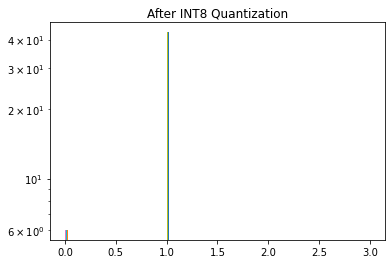

In [77]:
# Initialize lists to store true and predicted values
true_pts_quantized = []
pred_pts_quantized = []

# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)

    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]

    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q

    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")

    # Reshape to match the expected shape
    X_q_reshaped = np.resize(X_q_padded, target_shape)

    # Print the shape for debugging
    print(f"Shape of X_q_reshaped: {X_q_reshaped.shape}")

    # Set input tensor
    interpreter_quantized.set_tensor(input_details[0]['index'], X_q_reshaped)

    # Run inference
    start_time = time.time()
    interpreter_quantized.invoke()
    end_time = time.time()
    inference_times_quantized.append(end_time - start_time)

    # Get output tensor
    output_tensor_quantized = interpreter_quantized.get_tensor(output_details[0]['index'])

    # Process the output as needed
    # Assuming a classification task with softmax output
    predicted_probabilities_quantized = output_tensor_quantized[0]

    # Get the confidence score for the true class
    confidence_score_quantized = predicted_probabilities_quantized[ mask_true_particles[0, :111]]

    # Get the predicted class (index with the highest probability)
    predicted_class_quantized = np.argmax(predicted_probabilities_quantized, axis=1)
    
    # Extract the first row for boolean indexing
    mask_true_particles_row = mask_true_particles[0, :10]
    
    # Append true and predicted pt values
    true_pt_quantized = ys[ibatch][mask_true_particles_row, 2]
    pred_pt_quantized = confidence_score_quantized  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)
    
# After the loop, concatenate true and predicted pt values
true_pt_quantized = np.concatenate(true_pts_quantized)
pred_pt_quantized = np.concatenate(pred_pts_quantized)

# Print the final shapes for debugging
print(f"Final shape of true_pt_quantized: {true_pt_quantized.shape}")
print(f"Final shape of pred_pt_quantized: {pred_pt_quantized.shape}")

# Plot the histogram
plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 100))
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.show()


/tmp/sraj/ipykernel_1160579/225353060.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))
/tmp/sraj/ipykernel_1160579/225353060.py:6: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


(array([[ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         113.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         106.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0

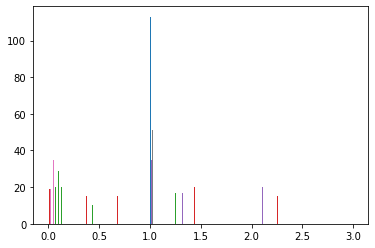

In [78]:
# Repeat the true_pt_quantized to match or exceed the length of pred_pt_quantized
repetition_factor = (pred_pt_quantized.shape[0] + true_pt_quantized.shape[0] - 1) // true_pt_quantized.shape[0]
true_pt_quantized_repeated = np.repeat(true_pt_quantized, repetition_factor, axis=0)[:pred_pt_quantized.shape[0]]

# Perform element-wise division
plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


/tmp/sraj/ipykernel_1160579/3367825139.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 50), label='Method 1')
/tmp/sraj/ipykernel_1160579/3367825139.py:1: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 50), label='Method 1')
/tmp/sraj/ipykernel_1160579/3367825139.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 50), label='Method 2', alpha=0.5)
/tmp/sraj/ipykernel_1160579/3367825139.py:2: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 50), label='Method 2', alpha=0.5)


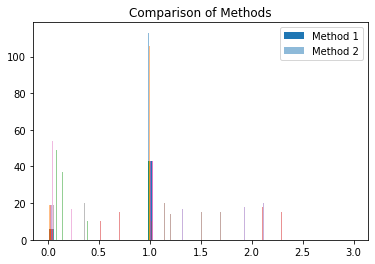

In [79]:
plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 50), label='Method 1')
plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 50), label='Method 2', alpha=0.5)
plt.title("Comparison of Methods")
plt.legend()
plt.show()


In [80]:
## Plotting the quantized true P_t and Predicted P_t
import ROOT
canvas = ROOT.TCanvas("canvas", "Quantized True and Predicted PT", 800, 600)

true_pt_array = np.array(true_pt_quantized)
pred_pt_array = np.array(pred_pt_quantized)

true_hist = ROOT.TH1F("true_hist", "True PT", 100, 0, 100)  # Adjust the binning as needed
pred_hist = ROOT.TH1F("pred_hist", "Predicted PT", 100, 0, 100)

# Filling histograms
for value in true_pt_array:
    true_hist.Fill(value)

for value in pred_pt_array:
    pred_hist.Fill(value)

# Set histogram properties
true_hist.SetLineColor(ROOT.kBlue)
pred_hist.SetLineColor(ROOT.kRed)

# Draw histograms
true_hist.Draw()
pred_hist.Draw("SAME")  # Draw on the same canvas

# Add legend
legend = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
legend.AddEntry(true_hist, "True Pt", "l")
legend.AddEntry(pred_hist, "Predicted Pt", "l")
legend.Draw()

# Set axis titles
true_hist.GetXaxis().SetTitle("Pt(GeV/c)")
true_hist.GetYaxis().SetTitle("Count")

# Show the canvas
canvas.Draw()


TypeError: none of the 3 overloaded methods succeeded. Full details:
  int TH1::Fill(double x) =>
    TypeError: could not convert argument 1 (only size-1 arrays can be converted to Python scalars)
  int TH1::Fill(const char* name, double w) =>
    TypeError: takes at least 2 arguments (1 given)
  int TH1::Fill(double x, double w) =>
    TypeError: takes at least 2 arguments (1 given)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: true_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: pred_hist (Potential memory leak).


Above one is the fixed point quantization. Dynamic Range Quantization aims to quantize weights and activations based on their dynamic ranges during inference. TensorFlow Lite supports dynamic range quantization, and you can apply it to your model.

## Dynamic Range Quantization for the model

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.lite.python import lite_constants

In [20]:
# Convert the model to a TensorFlow Lite model with dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
dynamic_range_tflite_model = converter.convert()

2023-11-23 15:12:43.691986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-23 15:12:43.692270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-23 15:12:43.696331: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptbw9wujk
2023-11-23 15:12:43.745615: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-23 15:12:43.746057: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmptbw9wujk
2023-11-23 15:12:43.911304: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-23 15:12:44.546164: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmptbw9wujk
2023-11-23 15:12:44.910384: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 1214293

In [21]:
# Save the dynamically quantized model
with open('dynamic_range_quantized_model.tflite', 'wb') as f:
    f.write(dynamic_range_tflite_model)

In [22]:
# Assuming you have a TensorFlow Lite dynamic range quantized model (dynamic_range_tflite_model)
interpreter = tf.lite.Interpreter(model_content=dynamic_range_tflite_model)
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [25]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [23]:
# Lists to store true and predicted pt values
true_pts_quantized = []
pred_pts_quantized = []

# Measure inference time and process output for the quantized dataset
inference_times_quantized = []

# Run inference
interpreter.invoke()


In [26]:
# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])

import time

start_time = time.time()


In [27]:

# Create an interpreter for the dynamic range quantized model
interpreter_dynamic_range = tf.lite.Interpreter(model_content=dynamic_range_tflite_model)
interpreter_dynamic_range.allocate_tensors()


In [49]:
# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)

    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]

    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q

    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")
    
    
    # Reshape to match the expected shape
    X_q_reshaped = np.resize(X_q_padded, target_shape)

    # Print the shape for debugging
    print(f"Shape of X_q_reshaped: {X_q_reshaped.shape}")

    # Set input tensor
    interpreter_dynamic_range.set_tensor(input_details[0]['index'], X_q_reshaped)

    # Run inference
    start_time = time.time()
    interpreter_dynamic_range.invoke()
    end_time = time.time()
    inference_times_quantized.append(end_time - start_time)

    
    # Get output tensor
    output_tensor_dynamic_range = interpreter_dynamic_range.get_tensor(output_details[0]['index'])

    # Process the output as needed
    # Assuming a classification task with softmax output
    predicted_probabilities_dynamic_range = output_tensor_dynamic_range[0]

    # Get the confidence score for the true class
    confidence_score_dynamic_range = predicted_probabilities_dynamic_range[mask_true_particles[0, :111]]

    # Get the predicted class (index with the highest probability)
    predicted_class_dynamic_range = np.argmax(predicted_probabilities_dynamic_range, axis=1)

    # Extract the first row for boolean indexing
    mask_true_particles_row = mask_true_particles[0, :10]
    
    # Append true and predicted pt values
    true_pt_dynamic_range = ys[ibatch][mask_true_particles_row, 2]
    pred_pt_dynamic_range = confidence_score_dynamic_range  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_dynamic_range)
    pred_pts_quantized.append(pred_pt_dynamic_range)




Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)


Final shape of true_pt_dynamic_range: (80, 8)
Final shape of pred_pt_dynamic_range: (270, 1)


/tmp/ipykernel_42685/334781023.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_dynamic_range[:80] / true_pt_dynamic_range[:, 0], bins=np.linspace(0, 3, 100))
/tmp/ipykernel_42685/334781023.py:10: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_dynamic_range[:80] / true_pt_dynamic_range[:, 0], bins=np.linspace(0, 3, 100))


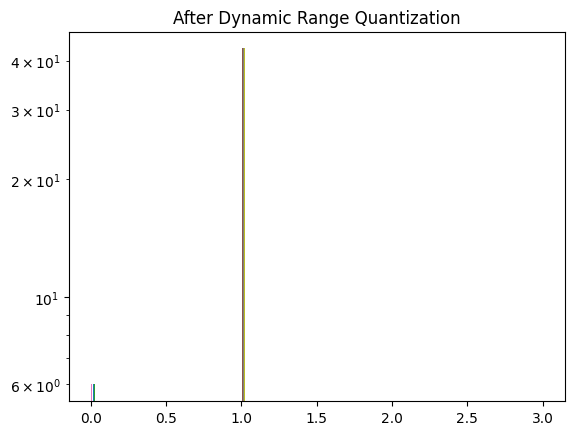

In [50]:
# After the loop, concatenate true and predicted pt values
true_pt_dynamic_range = np.concatenate(true_pts_quantized)
pred_pt_dynamic_range = np.concatenate(pred_pts_quantized)

# Print the final shapes for debugging
print(f"Final shape of true_pt_dynamic_range: {true_pt_dynamic_range.shape}")
print(f"Final shape of pred_pt_dynamic_range: {pred_pt_dynamic_range.shape}")

# Plot the histogram
plt.hist(pred_pt_dynamic_range[:80] / true_pt_dynamic_range[:, 0], bins=np.linspace(0, 3, 100))
plt.title("After Dynamic Range Quantization")
plt.yscale("log")
plt.show()

/tmp/ipykernel_42685/269767976.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_dynamic_range / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))
/tmp/ipykernel_42685/269767976.py:6: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_dynamic_range / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


(array([[ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         113.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         106.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0

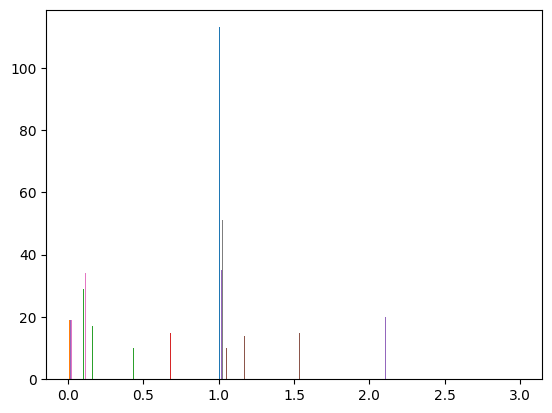

In [51]:
# Repeat the true_pt_quantized to match or exceed the length of pred_pt_quantized
repetition_factor = (pred_pt_dynamic_range.shape[0] + true_pt_dynamic_range.shape[0] - 1) // true_pt_dynamic_range.shape[0]
true_pt_quantized_repeated = np.repeat(true_pt_dynamic_range, repetition_factor, axis=0)[:pred_pt_dynamic_range.shape[0]]

# Perform element-wise division
plt.hist(pred_pt_dynamic_range / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


Let's try with the Full integer quantization 
## Full integer Quantization
Reductions in peak memory usage, and compatibility with integer only hardware devices or accelerators by making sure all model math is integer quantized.

For full integer quantization, you need to calibrate or estimate the range, i.e, (min, max) of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles. As a result, the converter requires a representative dataset to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data. Refer to the `representative_dataset()`function below.


Few links are:
1. https://www.tensorflow.org/lite/performance/post_training_integer_quant
2. https://www.tensorflow.org/lite/performance/post_training_quantization
3. https://www.tensorflow.org/lite/models/convert/
4. https://www.tensorflow.org/lite/performance/post_training_quant
5. https://www.tensorflow.org/lite/performance/post_training_float16_quant 
6. https://www.tensorflow.org/lite/performance/post_training_integer_quant_16x8 
7. https://www.tensorflow.org/lite/performance/quantization_spec 
8. https://arxiv.org/pdf/1712.05877.pdf

**Goal**: \
Target and goal is to convert the model  into the tensorflow quantized model and further after quantizing the dataset measure the inference time. 